In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///../../GWU-ARL-DATA-PT-12-2019-U-C/02-Homework/10-Advanced-Data-Storage-and-Retrieval/Instructions/Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base() #pulls the metadata; all the information about the table structures. Column names, types, number of, etc.
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
station_df=pd.read_sql('select * from station', con=engine)
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [8]:
# Calculate the date 1 year ago from the last data point in the database
measurement_df = pd.read_sql('select * from measurement', con=engine)
print(measurement_df['date'].max())
#max date is 2017-08-23

2017-08-23


# Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
year_df = pd.read_sql('select * from measurement where date >= "2016-08-23"', con=engine)
year_df.head()

,id,station,date,prcp,tobs
0,2364,USC00519397,2016-08-23,0.00,81.0
1,2365,USC00519397,2016-08-24,0.08,79.0
2,2366,USC00519397,2016-08-25,0.08,80.0
3,2367,USC00519397,2016-08-26,0.00,79.0
4,2368,USC00519397,2016-08-27,0.00,77.0


In [10]:
# Perform a query to retrieve the data and precipitation scores
year_ago = pd.read_sql('select * from measurement where date >= "2016-08-23"', con=engine)

# Save the query results as a Pandas DataFrame, sort the dataframe by date and set the index to the date column
year_ago.sort_values("date",inplace=True)
year_ago.set_index("date", inplace=True)
year_ago.drop(columns = ['id','tobs','station'], inplace=True)
year_ago.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


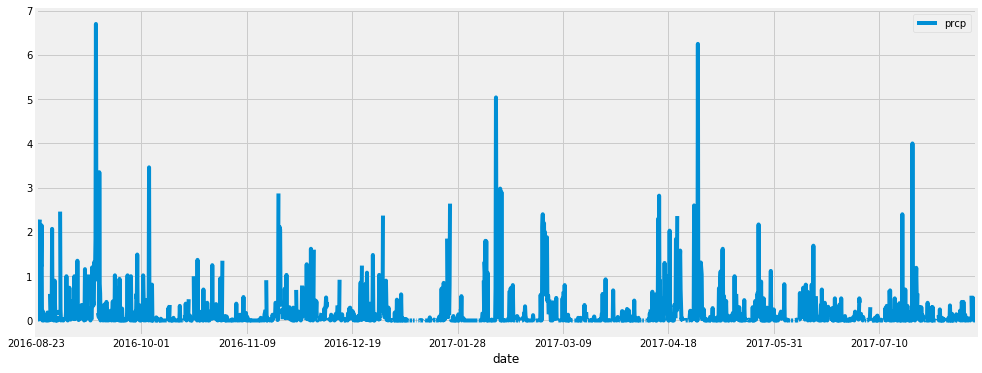

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
year_ago.plot(figsize = (15,6))

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_ago.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset? (9)
# SELECT COUNT ( DISTINCT station ) FROM measurement
session.query(func.count(Station.station)).all()

# pd.read_sql_query('select * from covid_country', con=engine).head()

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_group = year_df.groupby("station").count().sort_values(by='id', ascending=False)

station_group.head(9)

,id,date,prcp,tobs
station,,,,
USC00519397,361,361,359,361
USC00519281,352,352,352,352
USC00516128,349,349,328,349
USC00513117,343,343,343,343
USC00519523,337,337,314,337
USC00514830,305,305,265,305
USC00517948,183,183,60,183


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()



[(54.0, 85.0, 71.66378066378067),
 (56.0, 87.0, 74.55323054331865),
 (59.0, 85.0, 72.68918420081211),
 (56.0, 85.0, 74.5436493068565),
 (58.0, 84.0, 70.91500765696784),
 (58.0, 85.0, 74.8732970027248),
 (53.0, 87.0, 71.61596766043456),
 (58.0, 87.0, 74.68440233236151),
 (58.0, 83.0, 72.72407045009784)]

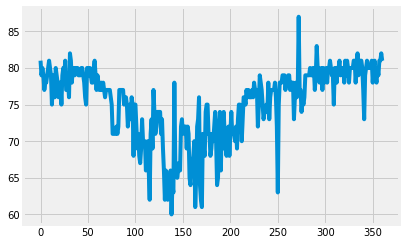

In [16]:
# Choose the station with the highest number of temperature observations. (USC00519397)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519397')\
    .filter(Measurement.date >= prev_year).all()

results_df = pd.DataFrame(results).rename(columns={"tobs":"temp"})
results_df.head()
plt.plot(results_df)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-02-28', '2018-03-05')
temps

[(58.0, 75.67857142857143, 87.0)]

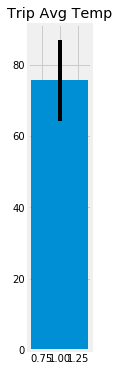

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr=np.array([temps[0][0],temps[0][2]])

plt.figure(figsize=(1, 6))
plt.title("Trip Avg Temp")
ax=plt.bar(1, temps[0][1], yerr=temps[0][1]-temps[0][2])

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_df = pd.read_sql('select * from station', con=engine)

station_rainfall = station_group.drop(columns=['tobs','date','id']).sort_values(by='prcp',ascending=False)

station_rainfall_merge = pd.merge(station_rainfall, station_df, on='station')
station_rainfall_merge

,station,prcp,id,name,latitude,longitude,elevation
0,USC00519397,359,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00519281,352,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,343,2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00516128,328,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00519523,314,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00514830,265,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
6,USC00517948,60,4,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Flask test

In [21]:
# # FLASK APP REF: https://github.com/davidwjones/AdvancedDataHomework/blob/master/app.py

# last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# #for jupyter debugging

# rain = session.query(Measurement.date, Measurement.prcp).\
#         filter(Measurement.date > last_year).all()

# total = 0
# min = 0
# max = 0
# counter=0

# for pair in rain:
#     try: 
#         float_pair = float(pair[1])
#         total += float_pair
#         counter+=1
#         if pair[1] > max: max = float_pair
#         elif pair[1] < min: min = float_pair
#     except TypeError: 
#         pass

# print(total)